In [2]:
pip install einops

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install datasets

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install transformer_lens

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... one
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 62.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.7 MB/s eta 0:00:00
  Created wheel for transformers-stream-generator: filename=transformers_stream_generator-0.0.5-py3-none-any.whl size=12425 sha256=9a530dda41a217e7f4d6626351ecd6fb7d01b61ab081eb2021d9259ff1cc88f2
  Stored in directory: /home/user/.cache/pip/wheels/a8/58/d2/014cb67c3cc6def738c1b1635dbf4e3dab6fb63aba7070dce0
Successfully built transformers-stream-generator
  Consider adding this directory to PATH or, i

In [4]:
from huggingface_hub import snapshot_download

local_dir = snapshot_download(
    repo_id="sa7270/tied-crosscoder",
    local_dir="checkpoints",   # choose your path
    resume_download=True,          # nice if it’s big
)
print("Files are in:", local_dir)

/home/user/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:943: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

tied_crosscoder_eta_2_cfg.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

tied_crosscoder_eta_2.pt:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/256 [00:00<?, ?B/s]

Files are in: /home/user/tied-crosscoder/checkpoints


In [5]:
from utils import *
from crosscoder import CrossCoder

cross_coder = CrossCoder.load('tied_crosscoder_eta_2')

{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.999,
 'buffer_mult': 128,
 'd_in': 2304,
 'dec_init_norm': 0.08,
 'device': 'cuda:0',
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'hook_point': 'blocks.14.hook_resid_pre',
 'l1_coeff': 2,
 'log_every': 100,
 'lr': 5e-05,
 'model_batch_size': 4,
 'model_name': 'gemma-2-2b',
 'num_tokens': 400000000,
 'save_every': 3000,
 'seed': 49,
 'seq_len': 1024,
 'site': 'resid_pre',
 'wandb_entity': 'santiago-aranguri-reg-new-york-university',
 'wandb_project': 'a'}


/home/user/tied-crosscoder/crosscoder.py:219: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [10]:
import torch

import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple
from typing import Callable, Any
import einops
class TopK(nn.Module):
    def __init__(self, k: int, postact_fn: Callable = nn.ReLU()) -> None:
        super().__init__()
        self.k = k
        self.postact_fn = postact_fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        topk = torch.topk(x, k=self.k, dim=-1)
        values = self.postact_fn(topk.values)
        # make all other values 0
        result = torch.zeros_like(x)
        result.scatter_(-1, topk.indices, values)
        return result

    def state_dict(self, destination=None, prefix="", keep_vars=False):
        state_dict = super().state_dict(destination, prefix, keep_vars)
        state_dict.update({prefix + "k": self.k, prefix + "postact_fn": self.postact_fn.__class__.__name__})
        return state_dict

    @classmethod
    def from_state_dict(cls, state_dict: dict[str, torch.Tensor], strict: bool = True) -> "TopK":
        k = state_dict["k"]
        postact_fn = ACTIVATIONS_CLASSES[state_dict["postact_fn"]]()
        return cls(k=k, postact_fn=postact_fn)
ACTIVATIONS_CLASSES = {
    "ReLU": nn.ReLU,
    "Identity": nn.Identity,
    "TopK": TopK,
}
class SAE(nn.Module):
  def __init__(self, batch_size: int,input_dim: int, expansion_factor: float = 8, device: str = 'cuda'): # Reorder arguments
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = 16384
        self.dtype=torch.float32
        self.W_dec = nn.Parameter(
            torch.nn.init.normal_(
                torch.empty(
                    self.latent_dim, input_dim, dtype=self.dtype
                )
            )
        )
        self.dtype=torch.float32
        #nn.init.kaiming_uniform_(self.decoder)
        self.W_enc = nn.Parameter(
            torch.empty( self.input_dim, self.latent_dim, dtype=self.dtype)  
        )
        self.W_dec.data = (
            self.W_dec.data / self.W_dec.data.norm(dim=-1, keepdim=True) * .08
        )
        self.W_enc.data = einops.rearrange(
            self.W_dec.data.clone(),
            "d_hidden d_model ->  d_model d_hidden",
        )
        self.b_enc = nn.Parameter(torch.zeros(self.latent_dim, dtype=self.dtype))
        self.b_dec = nn.Parameter(
            torch.zeros((self.input_dim), dtype=self.dtype)
        )
        self.batch_size=batch_size
        self.device=device
        self.l1_coefficient=3.2e-5
  def encode(self, x: torch.Tensor,k) -> torch.Tensor:
        
            
      
      topk=TopK(k=k)
      return topk(x@self.encoder+self.b_enc)
  def decode(self,encoded: torch.Tensor)-> torch.Tensor:
        return encoded@self.decoder+self.b_dec
  @torch.autocast(
        "cuda", dtype=torch.bfloat16, enabled=torch.cuda.is_bf16_supported() #speeds up forward by "2x"
    )
  def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    encoded=self.encode(x,128)
    final=self.decode(encoded)
    reconstruction_error_BD = (final - x).pow(2)
    reconstruction_error_B = einops.reduce(reconstruction_error_BD, 'B D -> B', 'sum')
    l2_loss = reconstruction_error_B.mean()

    
    loss = l2_loss

    nonzeros_per_sample = encoded.count_nonzero(dim=1)       

    
    avg_nonzeros = nonzeros_per_sample.float().mean() 
    return final,encoded,loss,avg_nonzeros

In [11]:
chat_dict=torch.load("gemma-2-2b-it-baseline_sae_layer_14_pre_resid-16384.pth")
base_dict=torch.load("gemma-2-2b-baseline_sae_layer_14_pre_resid-16384.pth")

chat_sae=SAE(8,2304)
base_sae=SAE(8,2304)
chat_sae.load_state_dict(chat_dict)
base_sae.load_state_dict(base_dict)

/tmp/ipykernel_1578/4131393884.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_1578/4131393884.py:2: FutureWarning:

You are using `torch.load` with `weig

<All keys matched successfully>

In [15]:
cross_coder.W_dec.data.shape

torch.Size([16384, 2, 2304])

In [13]:
pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [24]:
import torch
import umap 
base=base_sae.W_dec.data.cpu().numpy() 
chat=chat_sae.W_dec.data.cpu().numpy()
base_tied=cross_coder.W_dec[:,0,:].data.cpu().numpy() 
chat_tied=cross_coder.W_dec[:,1,:].data.cpu().numpy() 



umap_model = umap.UMAP(
    n_components=2, 
    min_dist=.05,# target dimensionality
    n_neighbors=15,        # tweak for local vs. global structure
    metric="cosine",       # cosine works well for neural activations
    random_state=42
)

embedding_base = umap_model.fit_transform(base)
embedding_chat=umap_model.fit_transform(chat)
embedding_chat_tied=umap_model.fit_transform(chat_tied)# shape (16384, 2)
embedding_base_tied=umap_model.fit_transform(base_tied)
# ─── 4)  (Optional) convert back to torch, save, or plot  ───────────────


# Example scatter plot


/home/user/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



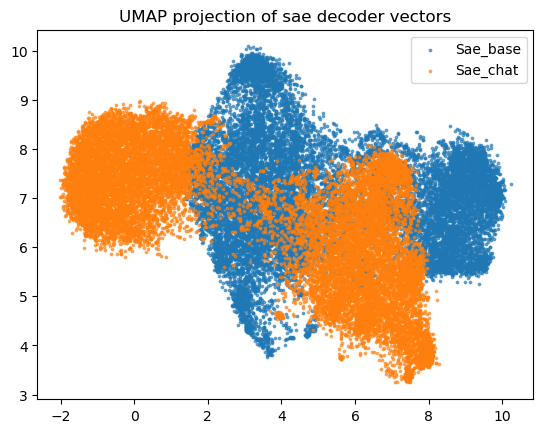

In [27]:
import matplotlib.pyplot as plt
plt.scatter(embedding_base[:,0], embedding_base[:,1], s=3, alpha=0.6,label="Sae_base")
plt.scatter(embedding_chat[:,0], embedding_chat[:,1], s=3, alpha=0.6,label="Sae_chat")
#plt.scatter(embedding_base_tied[:,0], embedding_base_tied[:,1], s=3, alpha=0.6,label="tied_base")
#plt.scatter(embedding_chat_tied[:,0], embedding_chat_tied[:,1], s=3, alpha=0.6,label="tied_chat")
plt.legend()
plt.title("UMAP projection of sae decoder vectors")
plt.show()